In [ ]:
# If data is imbalanced it might not be good to check accuracy score
# In this case accuracy score can be misleading for imbalanced data

# Classification Problem: Categories are distinct (Yes, No or 0,1) it is not a continuous scale
# Hence using a Logistic Regression is a better option and we cannot use Linear Regression as it is not a range or numerical values

# KNN Model does not do well with overlapped data as the data points are not separate and struggles with identifying separatability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
bikes = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/bikes_sharing.csv')

In [3]:
bikes.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bikes.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


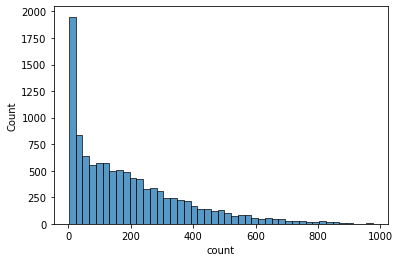

In [5]:
sns.histplot(bikes['count'])

In [6]:
# recreate time of day values

bikes['datetime'] = pd.to_datetime(bikes['datetime'])

In [7]:
bikes['hour'] = bikes['datetime'].apply(lambda x: x.hour)

In [8]:
# Filter for rush hour in evening and use that as a proxy for "high number of rentals" between (3:00 pm - 7:00 pm)
bikes[(bikes['hour'] >= 15) & (bikes['hour']<=19)]['count'].mean()

357.11491228070173

In [10]:
bikes['binary_output'] = bikes['count'].apply(lambda x: 1 if x>=357 else 0)

In [11]:
bikes.groupby('binary_output')['datetime'].count()

binary_output
0    9026
1    1860
Name: datetime, dtype: int64

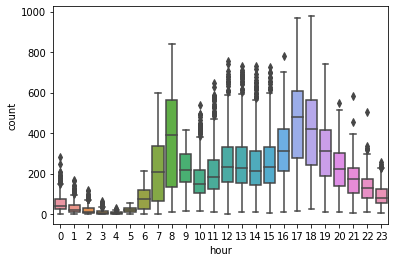

In [12]:
sns.boxplot(x = 'hour', y = 'count', data = bikes)

In [13]:
bikes.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'binary_output'],
      dtype='object')

In [14]:
# split data into X and Y variables
X = bikes[['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour']]
y = bikes['binary_output']

In [15]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
# MinMaxScaler: Scale values between 0 and 1
# The scaled values is still affected by outliers and depends on the number of outliers
# ML Models are affected by unscaled data(100:1000:10,000) as there is not a single scale hence scaling data is a better option

# For normalized data you will have to use a different scaling method and not a MinMaxScaler

MinMaxScaler().fit_transform(bikes[['temp',
       'atemp', 'humidity', 'windspeed']])

array([[0.2244898 , 0.30506768, 0.81      , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       [0.20408163, 0.28806354, 0.8       , 0.        ],
       ...,
       [0.32653061, 0.33896409, 0.61      , 0.26319502],
       [0.32653061, 0.3728605 , 0.61      , 0.10532503],
       [0.30612245, 0.35585636, 0.66      , 0.15786999]])

In [17]:
bikes[['temp', 'atemp', 'humidity', 'windspeed']]

,temp,atemp,humidity,windspeed
0,9.84,14.395,81,0.0000
1,9.02,13.635,80,0.0000
2,9.02,13.635,80,0.0000
3,9.84,14.395,75,0.0000
4,9.84,14.395,75,0.0000
...,...,...,...,...
10881,15.58,19.695,50,26.0027
10882,14.76,17.425,57,15.0013
10883,13.94,15.910,61,15.0013
10884,13.94,17.425,61,6.0032


In [ ]:
# OneHotEncoder will create new dummy variables for categorical variables

OneHotEncoder.fit_transform(bikes[['season', 'holiday', 'workingday']])

In [19]:
# build a pipeline that includes these transformations

numeric_columns = ['temp','atemp', 'humidity', 'windspeed']
categorical_columns = ['season', 'holiday', 'workingday', 'weather']

In [31]:
# ColumnTransformer: You can define different scaling data for multiple variables: categorical and numerical variables
# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [21]:
# KNNClassifies has a default_value(cv) = 5 (neighbours default value is 5)
# we are going to test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

In [22]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)

print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

c:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

0.4475617754802525
0.2160888821429261
0.4759934888351841


In [32]:
# build our pipeline
pipeline = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor),
                        ('classifier',KNeighborsClassifier())
                    ])

In [23]:
# We are choosing the KNNClassifier as the data(Hyperparameters) can be tuned and modified to suit for input variables(independent variables)
# NaiveBayes Model cannot be tuned and the score cannot be improved post its baseline
# Hyperparameters: n_neighbours, weights, metric, algorithm

# a quick side-quest demo of how KNN works
knn_15 = KNeighborsClassifier(n_neighbors=15).fit(X_train,y_train)
pred_15 = knn_15.predict(X_test)
print(accuracy_score(y_test, pred_15))
print(f1_score(y_test, pred_15))
print(precision_score(y_test, pred_15))
print(recall_score(y_test, pred_15))


0.8573178199632578
0.45433255269320844
0.6576271186440678
0.3470483005366726


In [24]:
# a quick side-quest demo of how KNN works
knn_30 = KNeighborsClassifier(n_neighbors=30).fit(X_train,y_train)
pred_30 = knn_30.predict(X_test)
print(accuracy_score(y_test, pred_30))
print(f1_score(y_test, pred_30))
print(precision_score(y_test, pred_30))
print(recall_score(y_test, pred_30))

0.8554807103490508
0.4010152284263959
0.6899563318777293
0.2826475849731664


In [29]:
# Grid search is used to find the best combination of hyperparameters for our problem by specifying different values
# Will build 7*2*3 = 42 different models for every different possible hyperparameters
# cv: CrossValidation i.e. the number of times the model will run for validation

param_grid = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}

In [33]:
# let's perform gridsearch
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring='f1')
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:   45.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         ['temp',
                                                                          'atemp',


In [34]:
print(grid_search.best_params_)

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


In [36]:
final_classifier = KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors'],
                                        metric = grid_search.best_params_['classifier__metric'],
                                        weights = grid_search.best_params_['classifier__weights']
                                        )

In [37]:
final_pipeline = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier)
                          ])

In [38]:
final_pipeline.fit(X_train,y_train)
pred = final_pipeline.predict(X_test)
probs = final_pipeline.predict_proba(X_test)

In [39]:
print(f1_score(y_test, pred))
print(accuracy_score(y_test,pred))
print(precision_score(y_test,pred))
print(recall_score(y_test,pred))

0.40944881889763785
0.8392529087568892
0.5515151515151515
0.32558139534883723
